LICENSE: Could not open license file "oe_license.txt" in local directory
LICENSE: N.B. OE_LICENSE environment variable is not set
LICENSE: N.B. OE_DIR environment variable is not set
LICENSE: No product keys!
LICENSE: No product keys!
LICENSE: No product keys!
LICENSE: No product keys!


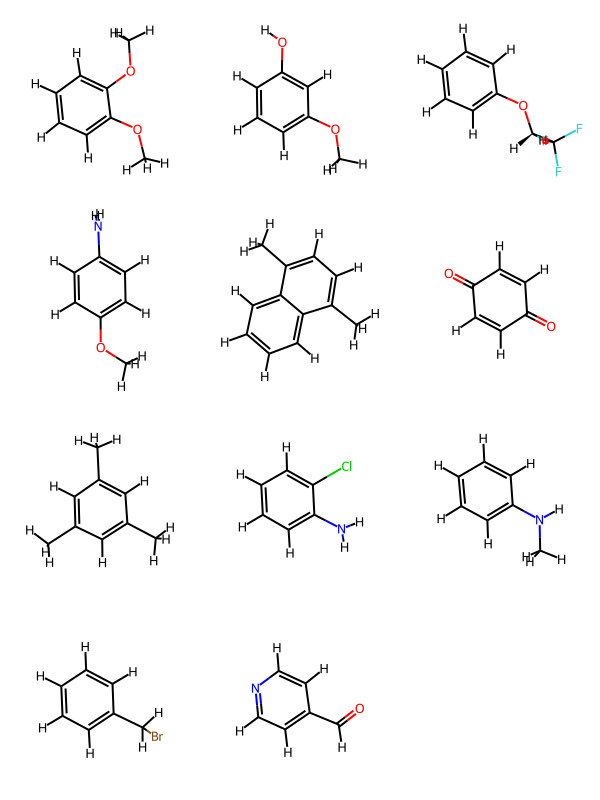

In [1]:
from rdkit import Chem
from openfe_benchmarks import benzenes
from kartograf import KartografAtomMapper
from openfe.setup.atom_mapping.lomap_scorers import default_lomap_score

system=benzenes.get_system()
compounds = system.ligand_components
compounds = [compounds[0]]+compounds[5:6]+compounds[7:]
Chem.Draw.MolsToGridImage ([c.to_rdkit() for c in compounds], )

In [2]:
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt

def draw_ligand_network(network, title="", ax=None):
    ligands = list(network.nodes)
    edge_map = {(m.componentA.name, m.componentB.name): m for m in network.edges}
    edges = list(sorted(edge_map.keys()))
    weights = [edge_map[k].annotations['score'] for k in edges]

    g = nx.Graph()
    [g.add_node(n.name) for n in ligands]
    g.add_weighted_edges_from(ebunch_to_add=[(e[0], e[1], w) for e,w in zip(edges,weights)])


    if(ax is None):
        fig = plt.figure(figsize=[16,9])
        ax = fig.gca()
    else:
        fig=None

    nx.draw_networkx(g, with_labels=True, ax=ax)
    ax.set_title(title+" Network #edges "+str(len(g.edges)))

    return fig

# Radial Network Layout

In [3]:
from konnektor.network_planners import RadialLigandNetworkPlanner
ligand_network_planner = RadialLigandNetworkPlanner(mapper=KartografAtomMapper(), scorer=default_lomap_score)

In [4]:
radial_network = ligand_network_planner(compounds)
radial_network.name="Radial"
radial_network

[LigandAtomMapping(componentA=SmallMoleculeComponent(name=lig_1), componentB=SmallMoleculeComponent(name=lig_14), componentA_to_componentB={8: 16, 10: 10, 12: 9, 13: 12, 14: 13, 15: 14, 16: 15, 0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7}, annotations={'score': 0.22119921692859512}), LigandAtomMapping(componentA=SmallMoleculeComponent(name=lig_6), componentB=SmallMoleculeComponent(name=lig_14), componentA_to_componentB={7: 15, 9: 10, 11: 8, 12: 12, 13: 13, 14: 14, 16: 16, 0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 8: 7}, annotations={'score': 0.1392920235749422}), LigandAtomMapping(componentA=SmallMoleculeComponent(name=lig_8), componentB=SmallMoleculeComponent(name=lig_14), componentA_to_componentB={1: 10, 13: 9, 14: 12, 15: 13, 16: 14, 17: 15, 18: 16, 3: 0, 5: 1, 6: 2, 7: 3, 8: 4, 9: 5, 10: 6, 11: 7}, annotations={'score': 0.36237184837822667}), LigandAtomMapping(componentA=SmallMoleculeComponent(name=lig_9), componentB=SmallMoleculeComponent(name=lig_14), componentA_to_componentB=

/tmp/ipykernel_10915/360503311.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


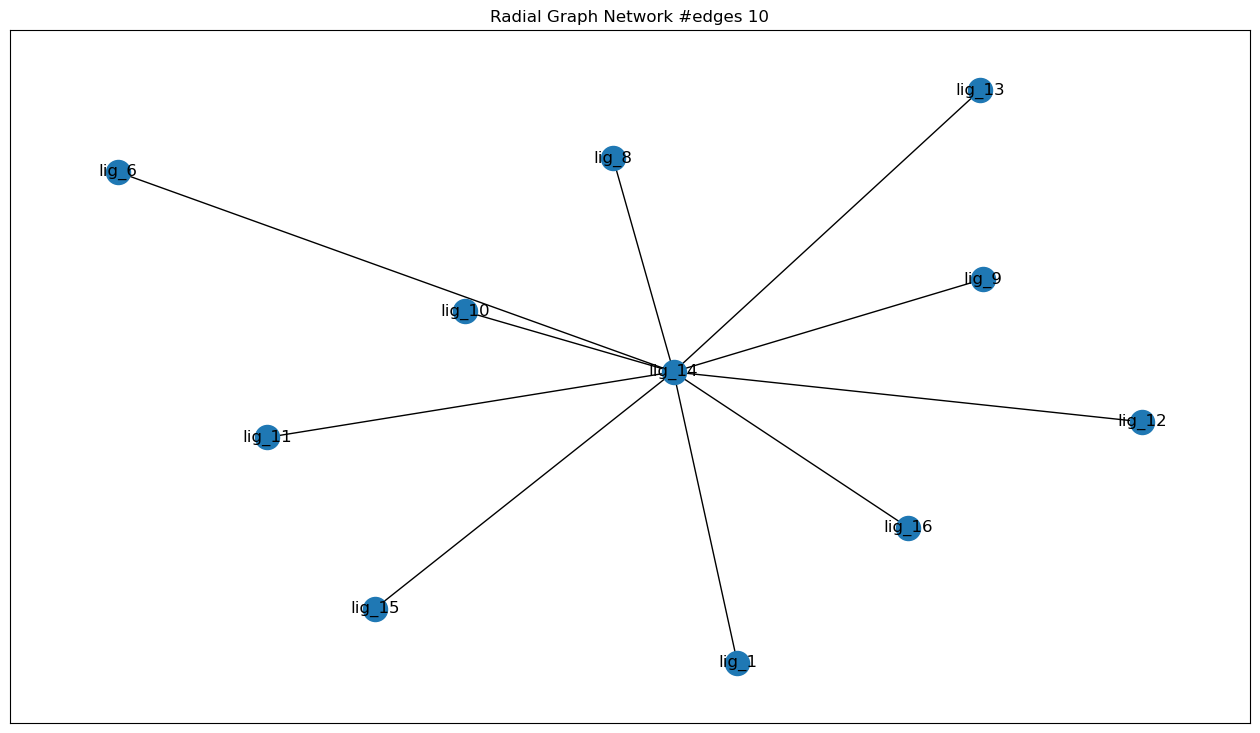

In [5]:
fig = draw_ligand_network(radial_network, title="Radial Graph");
fig.savefig(radial_network.name+"_Network.png")
fig.show()

# Minimal Spanning Tree

In [6]:
from konnektor.network_planners import MinimalSpanningTreeLigandNetworkPlanner

ligand_network_planner = MinimalSpanningTreeLigandNetworkPlanner(mapper=KartografAtomMapper(), scorer=default_lomap_score)

In [7]:
mst_network = ligand_network_planner(compounds)
mst_network.name="MST"
mst_network

/tmp/ipykernel_10915/2295833610.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


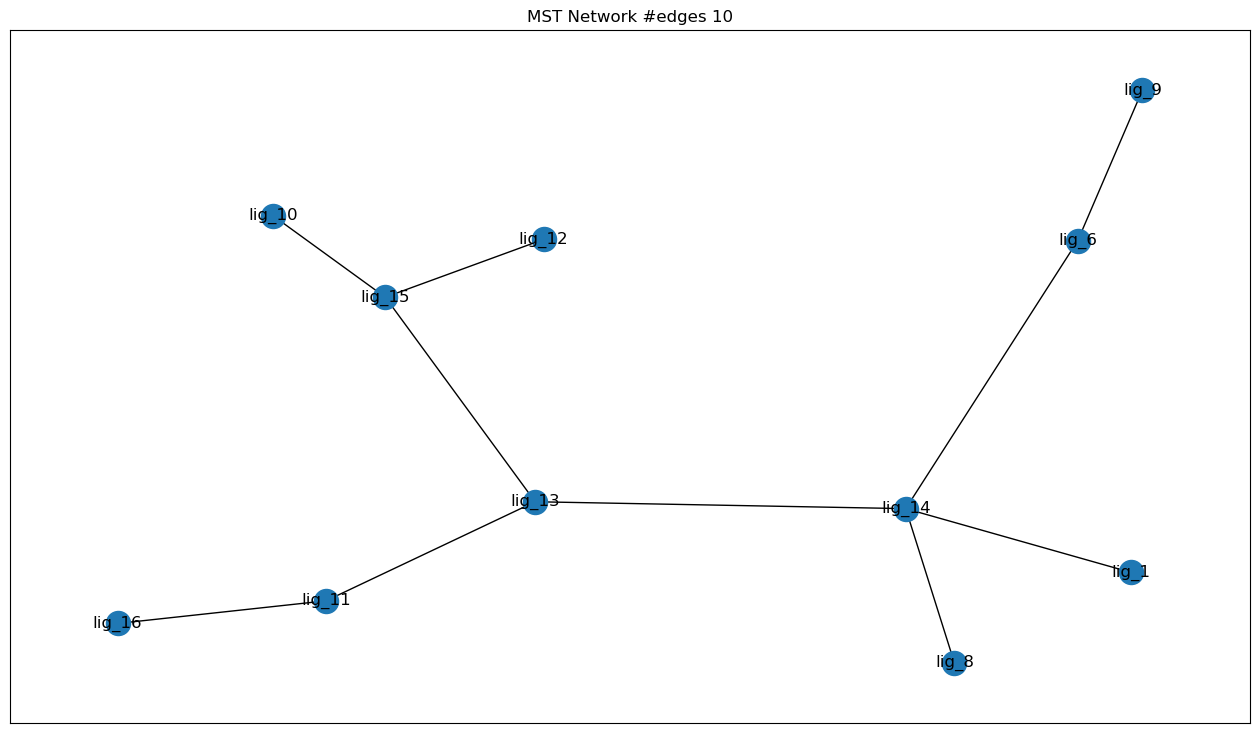

In [8]:
fig = draw_ligand_network(mst_network, "MST");
fig.savefig("MST_Network.png")
fig.show()

# Cyclo Graphs

In [9]:
from konnektor.network_planners import CyclicLigandNetworkPlanner
ligand_network_planner = CyclicLigandNetworkPlanner(mapper=KartografAtomMapper(), scorer=default_lomap_score,
                                                    cycle_sizes=3, node_present_in_cycles=1)

In [10]:
cyclic_network = ligand_network_planner(compounds)
cyclic_network.name="Cyclic"
cyclic_network

ERROR:	
Timings:
--------
ERROR:		 Cycle generation duration: 0:00:00.015659
ERROR:		 Cycle selection duration: 0:00:00.000338
ERROR:		 total duration: 0:00:00.016208


/tmp/ipykernel_10915/1302321791.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


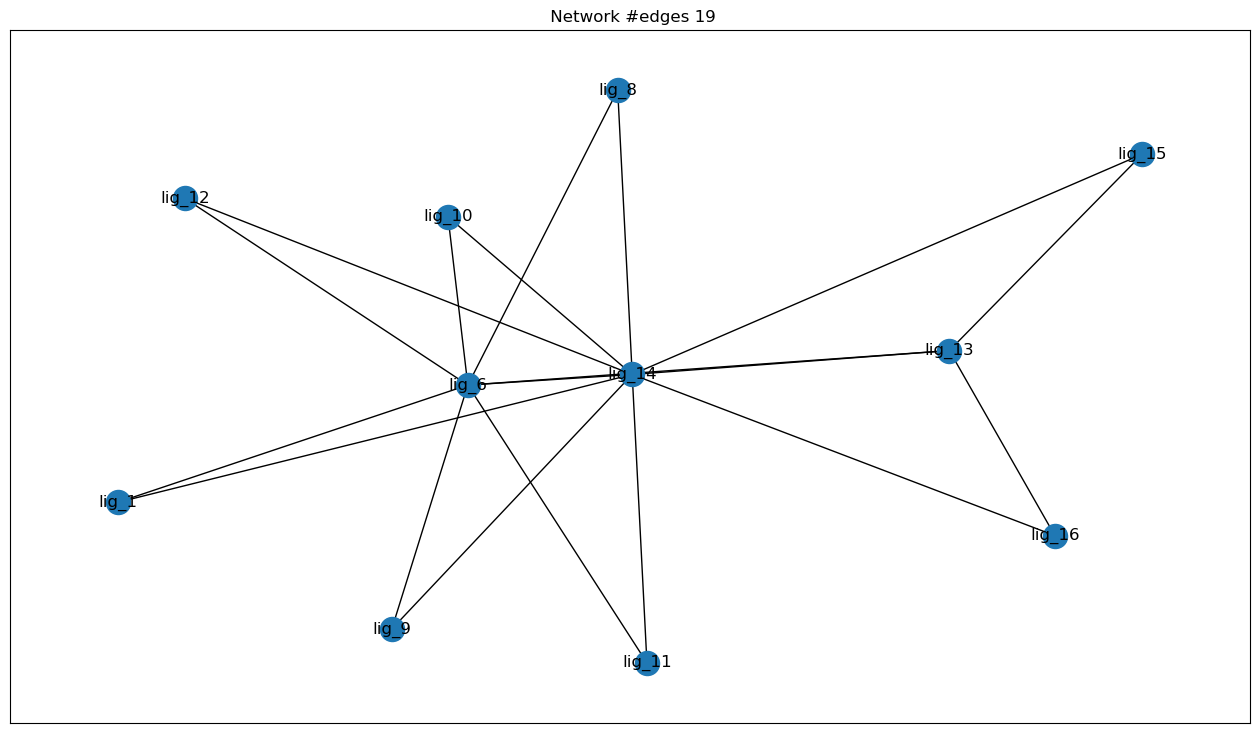

In [11]:
fig = draw_ligand_network(cyclic_network);
fig.savefig(cyclic_network.name+"_Network.png")
fig.show()

AttributeError: 'NoneType' object has no attribute 'orig_g'

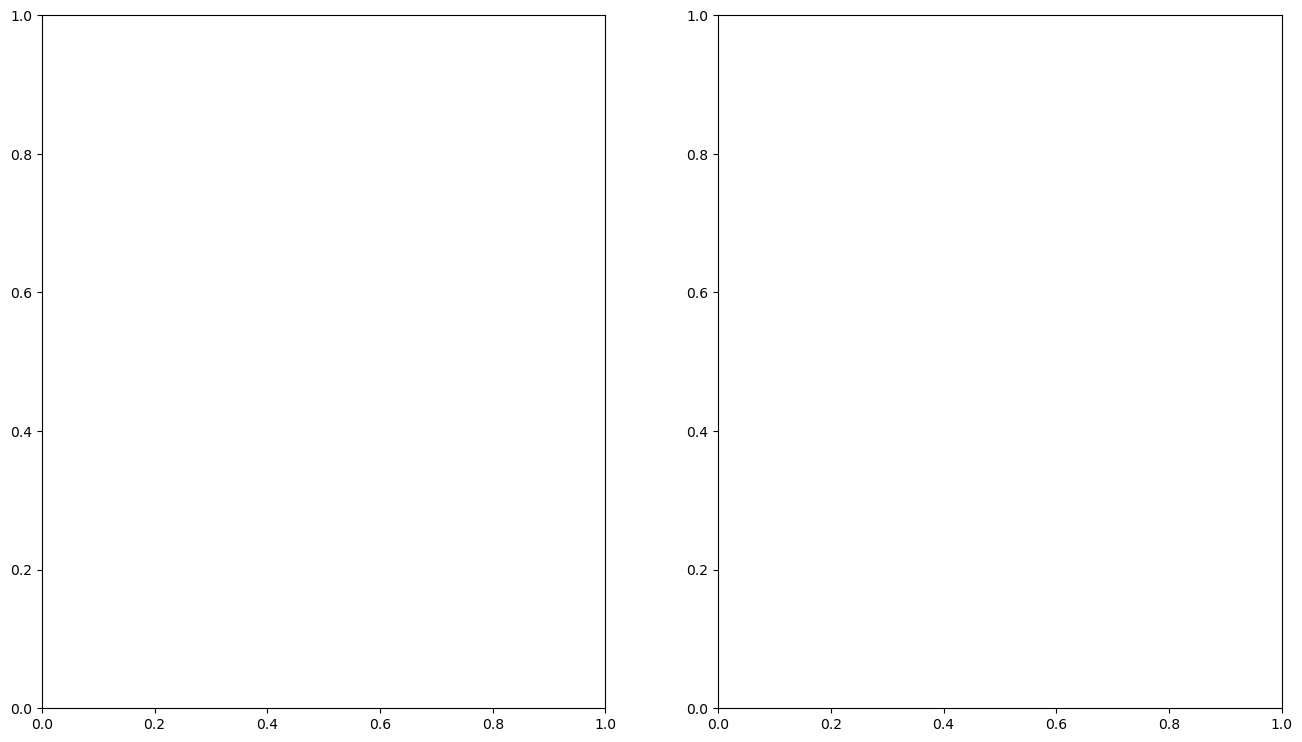

In [17]:
import networkx as nx
from matplotlib import pyplot as plt

ng=ligand_network_planner.network_generator
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=[16,9])
nx.draw_networkx(ng.orig_g, with_labels=True, ax=axes[0])
nx.draw_networkx(ng.cyclic_graph, with_labels=True, ax=axes[1])


axes[0].set_title("fully connected graph"+" #edges "+str(len(ng.orig_g.edges)))
axes[1].set_title("node in cycles "+str(ng.node_cycle_connectivity)+", cycle_size "+str(ng.sub_cycle_size_range)+" #edges "+str(len(ng.cyclic_graph.edges)))
fig.suptitle("Algorithm I")

# Maximally connected network

In [18]:
from konnektor.network_planners import MaximalNetworkPlanner
ligand_network_planner = MaximalNetworkPlanner(mapper=KartografAtomMapper(), scorer=default_lomap_score)

In [19]:
max_network = ligand_network_planner(compounds)
max_network.name = "Max"
max_network

/tmp/ipykernel_10915/323473944.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


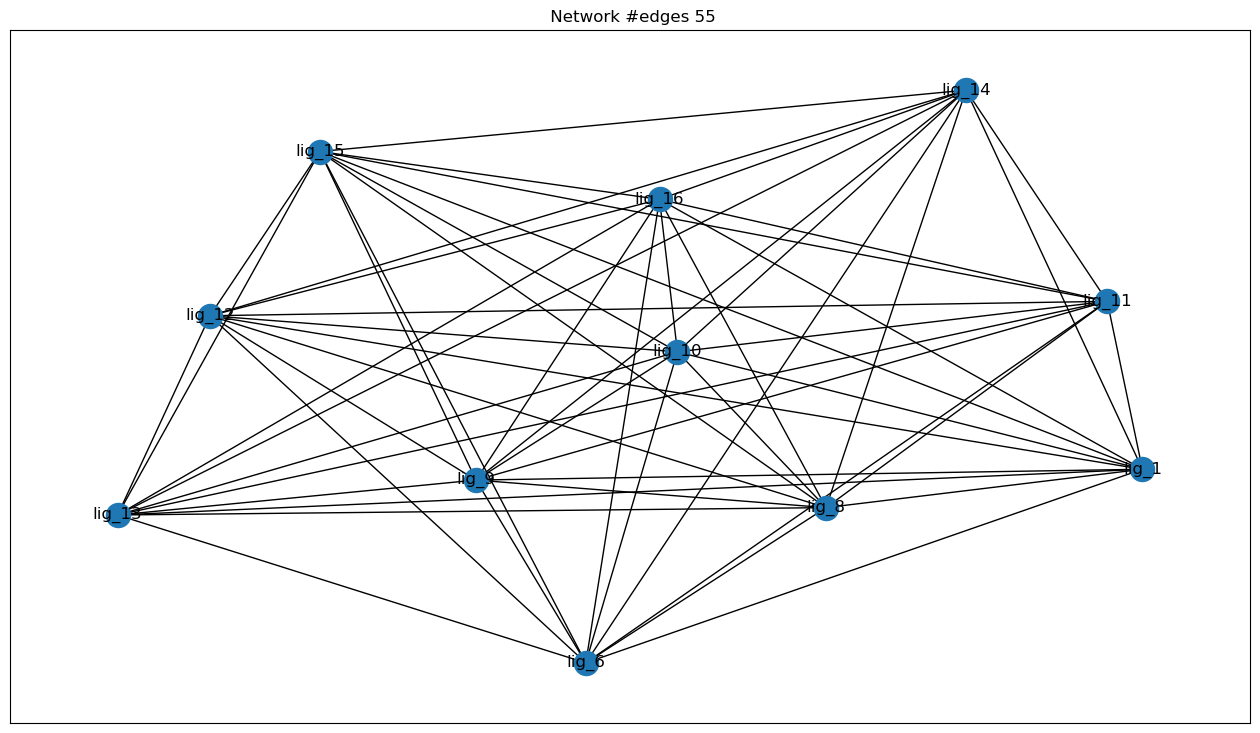

In [20]:
fig = draw_ligand_network(max_network);
fig.savefig(max_network.name+"_Network.png")
fig.show()

# Summary

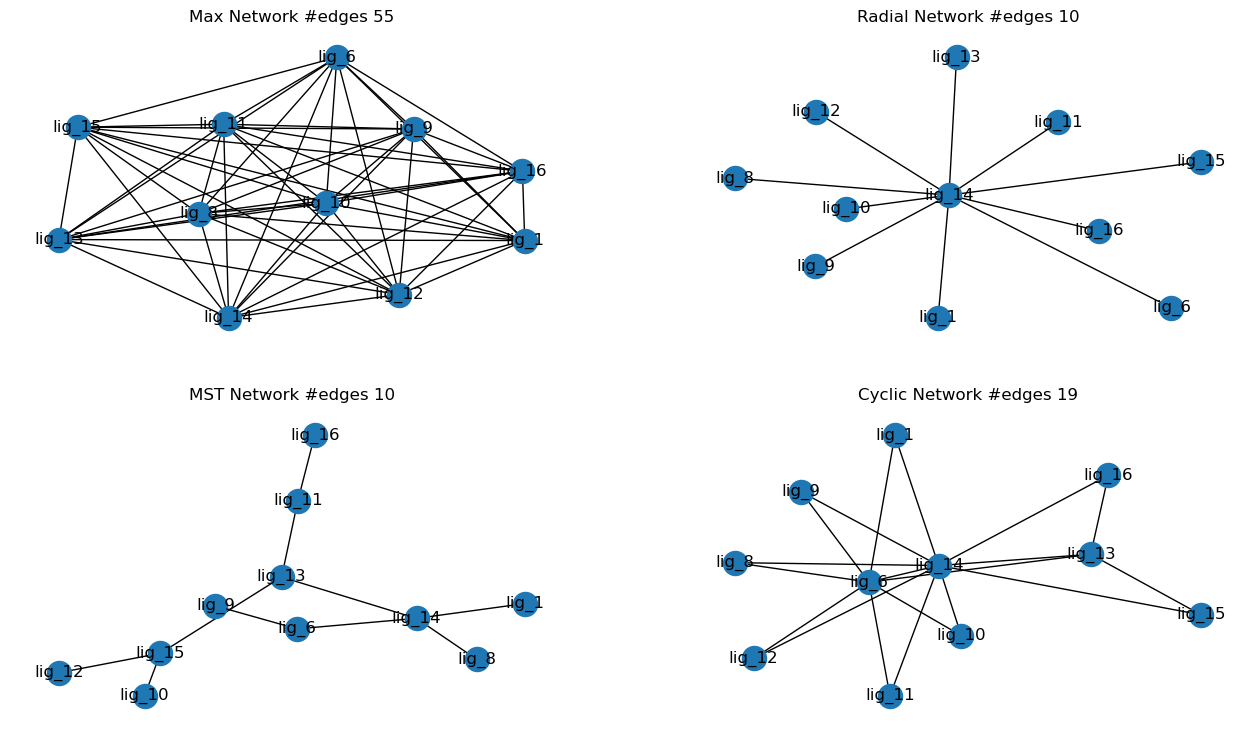

In [22]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=[16,9])
axes= np.array(axes).flat
for ax, net in zip(axes, [max_network, radial_network, mst_network, cyclic_network]):
    draw_ligand_network(network=net, title=net.name, ax=ax)
    ax.axis("off")


In [23]:
fig.savefig("network_layouts.png", dpi=400)